In [1]:
from __future__ import division
from IPython.display import display
from IPython.display import Markdown as md
from IPython.core.display import SVG
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.odr import *
import scipy.odr.odrpack as odrpack
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy

import sympy as sp
sf = sp.sympify

import scipy.constants as cm
import pint as pn
ureg = pn.UnitRegistry(system='mks')
ureg.default_format = '~P'
pe = ureg.parse_expression

## Konstanten und Einheiten
CM = pd.DataFrame(cm.physical_constants).T
CM['c'] = CM.index
CM = CM.reset_index(drop=True)
def getpc(quant):
    DF = CM
    DF = DF[DF['c']==quant].reset_index(drop=True)
    quan = DF[0][0] * ureg(DF[1][0])
    return quan
def addnoise(X,scale=0.01,lin=False):
    if not lin:
        mag = scale*(np.max(X.m)-np.min(X.m))
        return np.random.normal(0,mag,len(X.m))*X.u
    if lin:
        return np.random.normal(0,1,len(X.m))*X*scale
def uODR(func,beta0,xdata,ydata,**kwargs):
    xfit = kwargs.get('xfit',xdata)
    sx = kwargs.get('sx',None)
    sy = kwargs.get('sy',None)
    model = Model(func)
    data = RealData(xdata,ydata, sx=sx, sy=sy)
    odr = ODR(data, model, beta0=beta0)
    out = odr.run()
    # Estimated parameter values, of shape q
    p = out.beta
    # Standard errors of the estimated parameters, of shape p
    perr = out.sd_beta
    up =unumpy.uarray(p, perr)
    yfit=func(p, xfit) 
    return up , p, yfit, out

In [2]:
g = getpc('standard acceleration of gravity')
m_e = getpc('electron mass')
e = getpc('elementary charge')
c = getpc('speed of light in vacuum')
e0 = getpc('electric constant')
mu0 = getpc('mag. constant')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Quellcode an/aus schalten."></form>''')

# Übungen Wellenfunktion, Transmission und Reflexion


## Aufgabe 1
https://www.leifiphysik.de/mechanik/mechanische-wellen/aufgabe/verschiedene-diagramme

## Aufgabe 2
https://www.leifiphysik.de/mechanik/mechanische-wellen/aufgabe/harmonische-wellen

## Aufgabe 3
### a)
Der Punkt A startet bei $t=0$ nach oben, das bedeutet für die Wellenfunktion:
$$s(x,t) = -\hat{s} \cdot \sin{(k x-\omega t)}$$

In [12]:
s_ = pe('2cm')
T = pe('0.50s')
t_1 = pe('2.4s')

f = 1/T
omega = 2*np.pi*f

s = lambda t: -s_*np.sin(omega*t)

md("Gegeben: <br/>"
+ " $\\hat{{s}} = {:~P}$".format(s_) 
+ "; $T = {:~P}$".format(T)  
+ "; $t_1 = {:~P}$".format(t_1)  
+ "<br/>Lösung:<br/>" 
+ "$f = {:.2~P}$".format(f)
+ "; $\\omega = {:.3~P}$".format(omega)
+ "; $s(t_1) = {:.2~P}$".format(s(t_1)))

Gegeben: <br/> $\hat{s} = 2 cm$; $T = 0.5 s$; $t_1 = 2.4 s$<br/>Lösung:<br/>$f = 2.0 1/s$; $\omega = 12.6 1/s$; $s(t_1) = 1.9 cm$

### b)


In [11]:
s_ = pe('2cm')
T = pe('0.50s')
t_1 = pe('2.4s')

f = 1/T
omega = 2*np.pi*f

v = lambda t: -s_*omega*np.cos(omega*t)

md("Gegeben: <br/>"
+ " $\\hat{{s}} = {:~P}$".format(s_) 
+ "; $T = {:~P}$".format(T)  
+ "; $t_1 = {:~P}$".format(t_1)  
+ "<br/>Lösung:<br/>" 
+ "$f = {:.2~P}$".format(f)
+ "; $\\omega = {:.3~P}$".format(omega)
+ "; $v(t_1) = {:.2~P}$".format(v(t_1)))

Gegeben: <br/> $\hat{s} = 2 cm$; $T = 0.5 s$; $t_1 = 2.4 s$<br/>Lösung:<br/>$f = 2.0 1/s$; $\omega = 12.6 1/s$; $v(t_1) = -7.8 cm/s$

### c)

Gegeben: <br/> $t_2 = 1.125 s$; $c = 0.2 m/s$; $x_0 = 25 cm$<br/>Lösung:<br/>$\lambda = 10.0 cm$; $T = 0.5 s$; $k = 0.63 1/cm$; $\omega = 12.6 1/s$

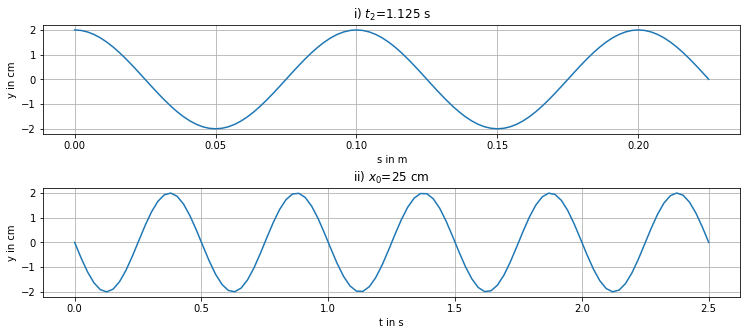

In [16]:
pars =  {
            's_' : pe('2cm'),
            's_0' : pe('25cm'),
            'T'  : pe('0.50s'),
            't_2' : pe('1.125s'),
            't_3' : pe('2.5s'),
            'c'  : pe('0.20m/s'),
        }
pars['s'] = np.linspace(0,(pars['c']*pars['t_2']).to('m').m,100)*pe('m')
pars['t'] = np.linspace(0,(pars['t_3']).to('s').m,100)*pe('s')
pars['lam'] = (pars['c'] * pars['T']).to('cm')
pars['k'] = (2*np.pi/pars['lam'])
pars['omega'] = (2*np.pi/pars['T'])

####

fig, ax = plt.subplots(2,1,sharex=False,figsize=tuple(np.array([5,2])*2.5))
fig.subplots_adjust(wspace = 0.1,hspace = 0.5)
try: ax = list(ax.flatten())
except: ax = [ax]

X = pars['t'].to('s')
Y = -pars['s_']*np.sin(pars['k']*pars['s_0']-pars['omega']*X)

ax[1].plot(X.m,Y.m,'-')#,linestyle='None')
ax[1].set_title(u'ii) $x_0$=%s'%("{:~P}".format(pars['s_0'])))
ax[1].set_xlabel(u't in %s'%("{:~P}".format(X.u)))
ax[1].set_ylabel(u'y in %s'%("{:~P}".format(Y.u)))

#ax[0].xaxis.set_major_locator(plt.MultipleLocator(1))
#ax[0].yaxis.set_major_locator(plt.MultipleLocator(0.5))
#ax[0].xaxis.set_minor_locator(plt.MultipleLocator(0.2))
#ax[0].yaxis.set_minor_locator(plt.MultipleLocator(1))

X = pars['s'].to('m')
Y = -pars['s_']*np.sin(pars['k']*X-pars['omega']*pars['t_2'])

ax[0].plot(X.m,Y.m,'-')#,linestyle='None')
ax[0].set_title(u'i) $t_2$=%s'%("{:~P}".format(pars['t_2'])))
ax[0].set_xlabel(u's in %s'%("{:~P}".format(X.u)))
ax[0].set_ylabel(u'y in %s'%("{:~P}".format(Y.u)))


ax[0].grid(True,which='both')
ax[1].grid(True,which='both')
#lims = ax[0].set_xlim(left=0)
#lims = ax[0].set_ylim(bottom=0)

#fig.savefig('A12_fig1.svg', bbox_inches='tight', pad_inches=0, dpi=400)

md("Gegeben: <br/>"
+ " $t_2 = {:~P}$".format(pars['t_2'])  
+ "; $c = {:~P}$".format(pars['c'])
+ "; $x_0 = {:~P}$".format(pars['s_0'])
+ "<br/>Lösung:<br/>" 
+ "$\\lambda = {:~P}$".format(pars['lam'])
+ "; $T = {:.3~P}$".format(pars['T'])
+ "; $k = {:.2~P}$".format(pars['k'])
+ "; $\\omega = {:.3~P}$".format(pars['omega']))


## Aufgabe 4

### a)
Da das Seil an beiden Ende gespannt ist, muss die Zugkraft in jedem Element des Seils gleich sein. Man vergleicht das Verhältnis der Ausbreitungsgeschwindigkeiten (die Zugkraft F kürzt sich):
$$\frac{c_2}{c_1} = \sqrt{\frac{\rho_1}{\rho_2}}$$

In [7]:
rho1 = pe('0.1kg/m')
rho2 = pe('0.2kg/m')

c2c1 = np.sqrt(rho1/rho2)

md("Gegeben: <br/>"
+ " $\\rho_1 = {:~P}$".format(rho1) 
+ "; $\\rho_2 = {:~P}$".format(rho2)   
+ "<br/>Lösung:<br/>" 
+ "$c_2/c_1 = {:.2~P}$".format(c2c1))

Gegeben: <br/> $\rho_1 = 0.1 kg/m$; $\rho_2 = 0.2 kg/m$<br/>Lösung:<br/>$c_2/c_1 = 0.71$

In dem schwereren Teil ist die Ausbreitungsgeschwindigkeit nur ca 71% der Ausbreitungsgeschwindigkeit des leichten Teils.

### b)
Benachbarte Seilelemente regen sich gegenseitig zu einer Schwingung an. Im Fall er angeregten Schwingung, folgt die Frequenz des Systems der Frequenz des Erregers.

### c)
Da für die Wellenlängen $\lambda = c \cdot T$ gilt, und die Periodendauern gleich sind, folgt das gleiche Ergebnis für das Verhältnis der Wellenlängen $\frac{\lambda_2}{\lambda_1}$ in beiden Abschnitten wie das der Ausbreitungsgeschwindigkeiten (siehe a)).

### d)
Die Wellenfunktion des leichteren Teils ist gegeben. Da die Wellenzahl k angegeben ist, folgt direkt für die Wellenlänge $$\lambda = \frac{2 \pi}{k}$$

In [8]:
k_1 = pe('6.0/m')

lamda_1 = 2*np.pi/k_1

md("Gegeben: <br/>"
+ " $k_1 = {:.2~P}$".format(k_1)    
+ "<br/>Lösung:<br/>" 
+ "$\\lambda_1 = {:.3~P}$".format(lamda_1))

Gegeben: <br/> $k_1 = 6.0 1/m$<br/>Lösung:<br/>$\lambda_1 = 1.05 m$

### e)
Mit $c=\frac{\omega}{k}$ lässt sich die Ausbreitungsgeschwindigkeit aus der bekannten Kreisfrequenz (siehe d)) berechnen. Es gilt:
$$\begin{eqnarray}
c_1 &=& \frac{\omega}{k_1} = \sqrt{\frac{F}{\rho_1}} \\
F &=& \frac{\omega^2 \cdot\rho_1}{k_1^2}
\end{eqnarray}$$

$$\begin{eqnarray}
\frac{k_1}{k_2} &=& \frac{\lambda_2}{\lambda_1} = \frac{c_2}{c_1} \\
\end{eqnarray}$$

In [9]:
k_1 = pe('6.0/m')
omega = pe('12Hz')
rho1 = pe('0.1kg/m')

c_1 = omega/k_1
F = (c_1**2*rho1).to('N')

md("Gegeben: <br/>"
+ " $k_1 = {:~P}$".format(k_1)
+ "; $\\omega = {:~P}$".format(omega)
+ "; $\\rho_1 = {:~P}$".format(rho1)
+ "<br/>Lösung:<br/>" 
+ "$F = {:~P}$".format(F))

Gegeben: <br/> $k_1 = 6.0 1/m$; $\omega = 12 Hz$; $\rho_1 = 0.1 kg/m$<br/>Lösung:<br/>$F = 0.4 N$

### f)
Die Kraft und die Frequenz ändern sich nicht. Deswegen gelten die Verhältnisse (aus a) und c)) mit dem Zusammenhang $k = \frac{2 \pi}{\lambda}$:

$$\begin{eqnarray}
\frac{k_1}{k_2} &=& \frac{\lambda_2}{\lambda_1} = \frac{c_2}{c_1} \\
\lambda_2 &=& \frac{c_2}{c_1} \cdot \lambda_1 \\
&=& \sqrt{\frac{\rho_1}{\rho_2}} \cdot \lambda_1 \\
&=& \sqrt{\frac{\rho_1}{\rho_2}} \cdot \frac{2 \pi}{k_1}
\end{eqnarray}$$

In [10]:
k_1 = pe('6.0/m')
rho1 = pe('0.1kg/m')
rho2 = pe('0.2kg/m')
lamda_1 = 2*np.pi/k_1

lamda_2 = (np.sqrt(rho1/rho2) * lamda_1).to('m')

md("Gegeben: <br/>"
+ " $k_1 = {:~P}$".format(k_1)
+ "; $\\rho_1 = {:~P}$".format(rho1)
+ "; $\\rho_2 = {:~P}$".format(rho2)
+ "<br/>Lösung:<br/>" 
+ "$\\lambda_2 = {:.2~P}$".format(lamda_2))

Gegeben: <br/> $k_1 = 6.0 1/m$; $\rho_1 = 0.1 kg/m$; $\rho_2 = 0.2 kg/m$<br/>Lösung:<br/>$\lambda_2 = 0.74 m$